In [166]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from scipy.signal import find_peaks, peak_widths
from scipy.ndimage import gaussian_filter1d  # For smoothing
from scipy.signal import argrelextrema


from numba import jit, njit

In [167]:
distance = []
arrG0 = []
arrGIMG = []
arr_en = []
arrGam = []
shift_0 = []
shift_IMG = []
arr_Edis = []

NG = 10

N_l = 0 #selected plateou

for nIMG in range(NG):
    Eshift_0 = np.zeros(2)
    Eshift_IMG = np.zeros(2)
    Gamma_img = np.zeros(2)
    
    #Function to re-import the data and parameters from target file
    # Read the parameters
    params_sys = {}
    with open('G_%d.dat' % (nIMG), 'r') as f:
        for line in f:
            if line.startswith("#"):
                key, value = line[1:].strip().split(" = ")
                params_sys[key] = float(value) if '.' in value or 'e' in value.lower() else int(value)
            else:
                break

    t, W, L, alpha, xic, plate_distance, E_dis, E_img, ei, ef, Ne, iter_dis, Ncore = params_sys.values()
    lB = 1./np.sqrt(2*np.pi*alpha)
    omB = 4*np.pi*alpha
    arr_Edis.append( E_dis/omB )
    
    distance.append( E_img/lB/np.abs( (plate_distance/lB)**2 )/omB )

    # Read the data
    data = pd.read_csv('G_%d.dat' % (nIMG), sep=' ', comment='#')

    energies = data['Energies'].to_numpy()
    G0 = data['G0'].to_numpy()
    GIMG = data['GIMG'].to_numpy()
    
    for nl in range(1):
        # Define a threshold: small fraction of max(fX)
        threshold_shift_IMG = .001 + (nl)
        threshold_shift_0 = .001 + (nl)
        # Find the first index where fX exceeds the threshold
        nonzero_indices_IMG = np.where(GIMG> threshold_shift_IMG)[0]
        Eshift_IMG[nl] = energies[nonzero_indices_IMG[-1]]
        # Find the first index where fX exceeds the threshold
        nonzero_indices_0 = np.where(G0 > threshold_shift_0)[0]
        Eshift_0[nl] = energies[nonzero_indices_0[-1]]
        
        Gamma_img[nl] = E_img/lB/np.abs( (plate_distance/lB)**2 ) * (nl+1)**.5
    
    shift_0.append(Eshift_0)
    shift_IMG.append(Eshift_IMG)
    
    arrG0.append( G0 )
    arrGIMG.append( GIMG )
    arr_en.append(energies)
    arrGam.append( Gamma_img )
arr_Edis = np.asarray(arr_Edis)

arrG0 = np.asarray(arrG0)
arrGIMG = np.asarray(arrGIMG)
arr_en = np.asarray(arr_en)
arrGam = np.asarray(arrGam)
shift_0 = np.asarray(shift_0)
shift_IMG = np.asarray(shift_IMG)
distance = np.asarray( distance )

In [168]:
from scipy.stats import linregress
from scipy.optimize import curve_fit

def rams(x, a, b, c, s, x0):
    x = x + x0
    A = a**2*np.exp(-2*(s*x)**1)/(4*(x)*((x)+a*np.exp(-(s*x)**1)))
    phi = np.sqrt(x+a*np.exp(-(s*x)) )*c
    B = np.cos(phi)*np.exp( - b )
    f = 1/(1+A/2*(1-B)  )
    filtered_fx = np.where(x > 0, f, 0)
    
    return filtered_fx

def rams0(x, a, x0):
    x = x + x0
    A = a**2/(4*(x)*((x)+a))
    f = 1/(1+A/2  )
    filtered_fx = np.where(x > 0, f, 0)
    return f

def rams_dis(x, a, gamma, fact, x0):
    x = x + x0
    A = a**2/(4*(x)*((x)+a))
    f = 1/(1+A**gamma * fact  )
    filtered_fx = np.where(x > 0, f, 0)
    return f

arrE_1 = np.zeros(len(distance))

slope_1 = np.zeros(len(distance))

inter_1 = np.zeros(len(distance))

arr_xmin = []
arr_ymin = []

arr_y1 = []
arr_x1 = []
arr_pop = []

N_L = 0

t_exp = -2
sigma_u = 1
for nG in range(NG):
    # Extract the interval
    Ein = 0.0001
    Eout = 1.
    if Eout <= 1.:
        ne0 = np.argmin( np.abs( Ein  - (arr_en[nG] - shift_IMG[nG][0])/ omB)  )
        nef = np.argmin( np.abs( Eout - (arr_en[nG] - shift_IMG[nG][0])/ omB) )
    else:
        ne0 = np.argmin( np.abs( 0.0001  - (arr_en[nG] - shift_IMG[nG][0])/ omB)  )
        nef = np.argmin( np.abs( 1. - (arr_en[nG] - shift_IMG[nG][0])/ omB) )
    y1 = np.abs(np.flip( arrGIMG[nG, nef:ne0] ))
    x1 = np.abs( np.flip( (arr_en[nG, nef:ne0]- shift_IMG[nG][0]) / omB ) )
    #arr_y1.append( y1 )
    #arr_x1.append( x1 )
    
    p0 = [ arrGam[nG,0]/omB, 1.4, 2, .04]
    popt1, pcov1 = curve_fit(rams_dis, x1, y1, p0=p0)
    y1_fit = rams_dis(x1, *popt1)
    slope_1[nG] = popt1[0]
    arr_pop.append(popt1)
    arr_y1.append( y1_fit )
    arr_x1.append( x1 )
    print(popt1, pcov1)


arr_pop = np.asarray(arr_pop)

[0.   1.4  2.   0.04] [[inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]]
[0.31292349 4.98411805 5.46503338 0.03779758] [[ 1.03740460e+01  3.19811689e+01 -9.72391633e+02  1.77853110e-01]
 [ 3.19811689e+01  9.86282683e+01 -2.99734146e+03  5.49014831e-01]
 [-9.72391633e+02 -2.99734146e+03  9.11487617e+04 -1.66635496e+01]
 [ 1.77853110e-01  5.49014831e-01 -1.66635496e+01  3.06400082e-03]]
[ 0.31465785  4.495211   26.16004965  0.04606561] [[ 1.33274663e+01  3.74314225e+01 -5.32362756e+03  2.41983638e-01]
 [ 3.74314225e+01  1.05145795e+02 -1.49509514e+04  6.80131377e-01]
 [-5.32362756e+03 -1.49509514e+04  2.12656788e+06 -9.66300925e+01]
 [ 2.41983638e-01  6.80131377e-01 -9.66300925e+01  4.40939092e-03]]
[0.24715846 2.52659808 4.13839745 0.01407775] [[ 2.16322122e+00  4.21019957e+00 -9.90334306e+01  3.38768354e-02]
 [ 4.21019957e+00  8.20145279e+00 -1.92683093e+02  6.61988263e-02]
 [-9.90334306e+01 -1.92683093e+02  4.53435690e+03 -1.54849526e+00]
 [ 3.38768354e-02  6

/var/folders/y4/dpq6l9fj2kv9z0prq_6_pyy00000gn/T/ipykernel_58472/1075495323.py:61: OptimizeWarning: Covariance of the parameters could not be estimated
  popt1, pcov1 = curve_fit(rams_dis, x1, y1, p0=p0)
/var/folders/y4/dpq6l9fj2kv9z0prq_6_pyy00000gn/T/ipykernel_58472/1075495323.py:24: RuntimeWarning: invalid value encountered in power
  f = 1/(1+A**gamma * fact  )


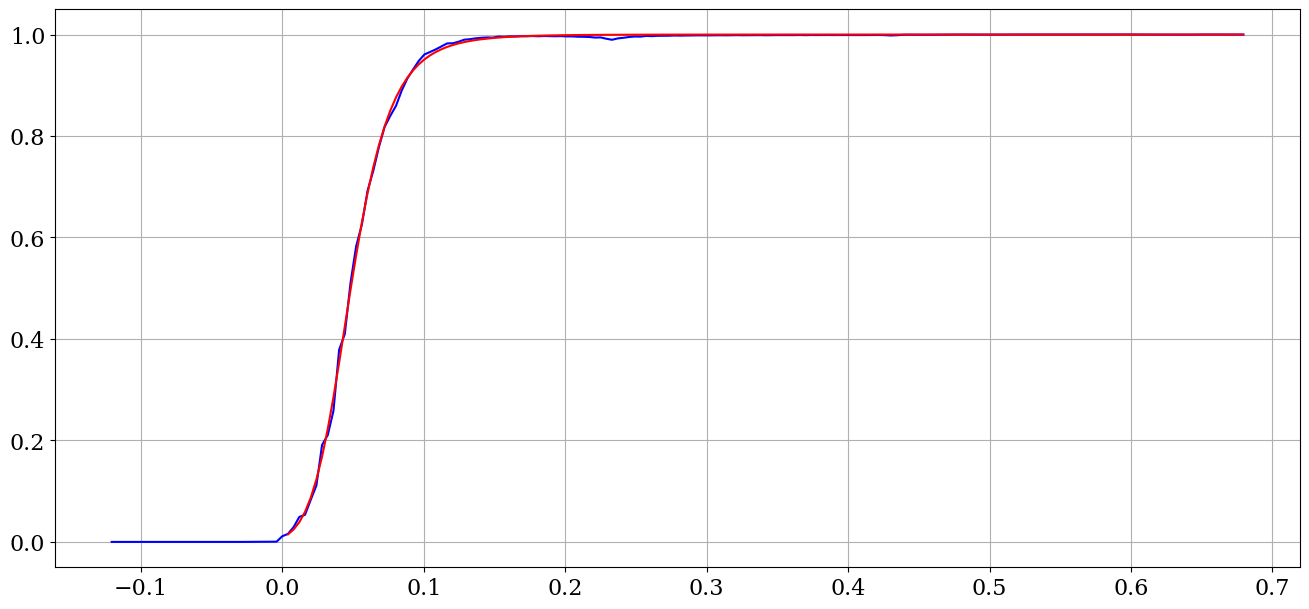

In [169]:
nG = 1
N_l = 0


plt.plot( (arr_en[nG] - shift_IMG[nG][N_l]) / omB, arrGIMG[nG], color='blue' )
plt.plot( arr_x1[nG], arr_y1[nG], color='red' )

y_fake = rams_dis(arr_x1[nG], arrGam[nG,0]/omB, 1.5, 2, -.001)
#plt.plot( arr_x1[nG], y_fake )

#plt.plot(arr_xmin[nG], arr_ymin[nG])



#plt.xlim(-.1,1.1)
#plt.ylim(0,1.1)
plt.grid()


plt.tight_layout()
plt.gcf().set_size_inches(370 / 25.4, 170 / 25.4)

/var/folders/y4/dpq6l9fj2kv9z0prq_6_pyy00000gn/T/ipykernel_58472/3492854906.py:116: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


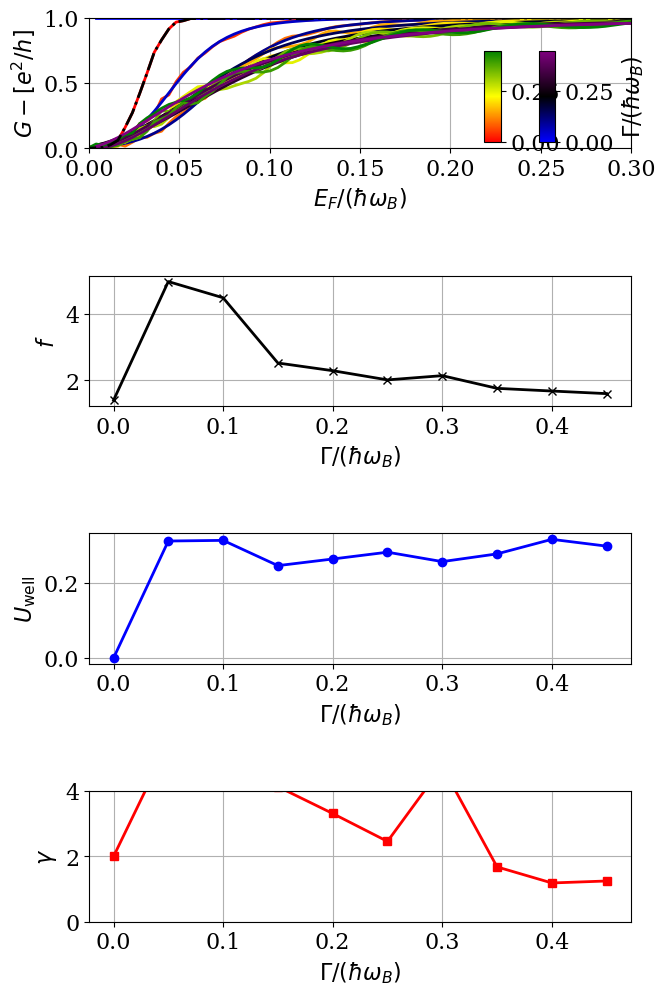

In [170]:
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors


# Second plot (blue curve, right y-axis)
norm = Normalize(vmin=min(distance), vmax=max(distance))  # Normalize gS values
cmap = mcolors.LinearSegmentedColormap.from_list("red_to_grey", ["red", "yellow", "green"])
cmap1 = mcolors.LinearSegmentedColormap.from_list("red_to_grey", ["blue", "black", "purple"])


# Font configuration
font = {
    'family': 'serif',
    'color': 'black',
    'weight': 'normal',
    'size': 16,
}
# Apply the font globally
plt.rcParams['font.family'] = font['family']
plt.rcParams['font.size'] = font['size']
plt.rcParams['axes.labelsize'] = font['size']
plt.rcParams['xtick.labelsize'] = font['size']
plt.rcParams['ytick.labelsize'] = font['size']

# Create the figure and subplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(8, 8))


N_l = 0

for nG in range(NG):
    color = cmap(norm(distance[nG]))
    color1 = cmap1(norm(distance[nG]))
    ax1.plot( (arr_en[nG] - shift_IMG[nG][N_l]) / omB, arrGIMG[nG], color=color, linewidth=2)
    ax1.plot( arr_x1[nG], arr_y1[nG], color=color1, linewidth=2)


ax1.plot( (arr_en[0]-shift_0[0][N_l] ) / omB, arrG0[0], color='black', linewidth=2, linestyle='-.')


ax1.set_ylabel(r"$G - [e^2/h]$", fontdict=font)
ax1.set_xlabel(r"$E_F/(\hbar\omega_B)$", fontdict=font)

ax1.set_xlim((np.amin(energies)/ omB,np.amax(energies)/omB))
xmin = 0
xmax = .5

ax1.set_ylim((0, 1.))
#ax1.set_yscale('log')
ax1.set_xlim((0, .3))
ax1.grid()




ax2.plot( distance, arr_pop[:,1], color='black', linestyle='-', marker='x', linewidth=2)

ax2.set_ylabel(r"$f$", fontdict=font)
ax2.set_xlabel(r"$\Gamma/(\hbar \omega_B)$", fontdict=font)

#ax2.set_ylim((1e-6, 1e0))
#ax2.set_xlim((xmin, xmax))

ax2.grid()


ax3.plot( distance, arr_pop[:,0], color='blue', linestyle='-', marker='o', linewidth=2)
ax3.set_ylabel(r"$U_{\rm well}$", fontdict=font)
ax3.set_xlabel(r"$\Gamma/(\hbar \omega_B)$", fontdict=font)

#ax2.set_ylim((1e-6, 1e0))
#ax2.set_xlim((xmin, xmax))

ax3.grid()


ax4.plot( distance, arr_pop[:,2], color='red', linestyle='-', marker='s', linewidth=2)
ax4.set_ylabel(r"$\gamma$", fontdict=font)
ax4.set_xlabel(r"$\Gamma/(\hbar \omega_B)$", fontdict=font)

ax4.set_ylim((0, 4))
#ax2.set_xlim((xmin, xmax))

ax4.grid()



from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# Create ScalarMappable for colorbar
sm = ScalarMappable(norm=norm, cmap=cmap)

# Inset for colorbar in ax1
cax = inset_axes(ax1, width="3%", height="70%", loc='center right',
                 bbox_to_anchor=(-.2, -.1, 1, 1), bbox_transform=ax1.transAxes, borderpad=1)

cbar = plt.colorbar(sm, cax=cax)
#cbar.set_label(r"$\Gamma/(\hbar \omega_B)$")

# Create ScalarMappable for colorbar
sm1 = ScalarMappable(norm=norm, cmap=cmap1)

# Inset for colorbar in ax1
cax1 = inset_axes(ax1, width="3%", height="70%", loc='center right',
                 bbox_to_anchor=(-.1, -.1, 1, 1), bbox_transform=ax1.transAxes, borderpad=1)

cbar = plt.colorbar(sm1, cax=cax1)
cbar.set_label(r"$\Gamma/(\hbar \omega_B)$")







plt.tight_layout()
plt.gcf().set_size_inches(170 / 25.4, 270 / 25.4)
#plt.savefig('GR_Nx%d_Ny%d_BW%.2f_dis%.2f_xic%.2f_IMG%.2f_alpha%.2f_W%dL%d_pltdist%d_T%.3f.svg' % (L, W, BandW0, dis, xic, IMG, alpha, W, L, plate_distance, T0))
#plt.savefig('GR_Nx%d_Ny%d_BW%.2f_dis%.2f_xic%.2f_IMG%.2f_alpha%.2f_W%dL%d_pltdist%d_T%.3f.pdf' % (L, W, BandW0, dis, xic, IMG, alpha, W, L, plate_distance, T0))
plt.show()